In [1]:
import pandas as pd
from python_speech_features import mfcc
from python_speech_features import logfbank
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from sklearn.utils import class_weight
from datetime import datetime
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2, l1
import librosa, librosa.display
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

%matplotlib inline

## Loading Data
### Loading the dataframe containing sound files arrays 

In [18]:
df = pd.read_hdf('audio_df.h5', 'raw')
df.head()

,audio,sampling_rate,length,label
0,"[2.2960085e-05, -0.00012982322, -0.00018070513...",22050,198450,artifact__
1,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",22050,198450,artifact__
2,"[3.728857e-05, -0.0001664555, -7.4023155e-05, ...",22050,198450,artifact__
3,"[-0.0027429417, -0.0066496185, -0.0049779303, ...",22050,198450,artifact__
4,"[0.000106223946, 0.0015002153, 0.0097254915, 0...",22050,198450,artifact__


### Number of examples per class

In [0]:
df.groupby('label').count()['length']

label
artifact__              40
extrahls__              19
extrastole__            46
murmur__               100
murmur_noisymurmur_     29
normal__               231
normal_noisynormal_    120
Name: length, dtype: int64

### Since noisy data is considered as a subtype, their labels are changed to the parent label

In [0]:
#labeling "noisy" as normal
df.loc[df['label'] == 'murmur_noisymurmur_', 'label'] = 'murmur__'
df.loc[df['label'] == 'normal_noisynormal_', 'label'] = 'normal__'

#thus the new distribution
df.groupby('label').count()

,audio,sampling_rate,length
label,,,
artifact__,40,40,40
extrahls__,19,19,19
extrastole__,46,46,46
murmur__,129,129,129
normal__,351,351,351


### Equalizing data length



585it [00:00, 3131.32it/s]


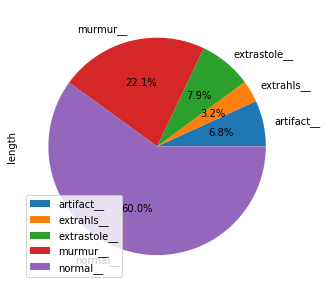

In [0]:
#funtion for repeating
def repeat_to_length(arr, length):
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    result[pos:pos+l] = arr
    
    #chaning now to ref
    pos += l
    l = len(arr)
    
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

MAX_LEN = 22050 * 6 # sampling rate * seconds

data = []

for row in tqdm(df.iterrows()):
  if len(row[1]['audio']) < MAX_LEN:
    audio = repeat_to_length(row[1]['audio'], MAX_LEN)
  else:
    audio = row[1]['audio'][:MAX_LEN]                                                
  
  data.append([audio, row[1]['sampling_rate'], len(audio), row[1]['label']])

df = pd.DataFrame(data, columns = ['audio', 'sampling_rate', 'length', 'label'])

dist = df.groupby('label').count()

#plotting the final distribution
dist.plot.pie(y='length', figsize=(5, 5), autopct='%1.1f%%')

It's evident that there is a high imblance in the dataset. This will be addressed later.

## Pre-Processing the Data
The audio signals are in the time domain which represents the changes in the amplitude with respect to time.

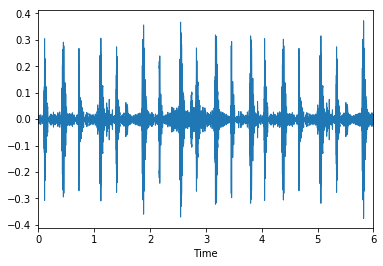

In [0]:
signal = df.loc[100]['audio']
label = df.loc[100]['label']
sampling_rate = df.loc[100]['sampling_rate']

librosa.display.waveplot(signal, sr=sampling_rate)

### Short Time Fourier Transform
The signal can be transformed into the frequency domain representation via Short Time Fourier Transform (STFT). STFT is obtained by segmenting a signal into frames of a few millisconds. Since the frame size is a very short time period, it is safe to assume that the signal is stationary within the frame. Direct Fourier Transform is then applied to them, thereby transforming the frames into the frequency domain. Thus the magnitude of various frequencies present in each frame at different points in time is obtained. 

The following video provides a good explaination of the process: https://youtu.be/g1_wcbGUcDY

Librosa provides a function to obtain the short time fourier transform of a signal.

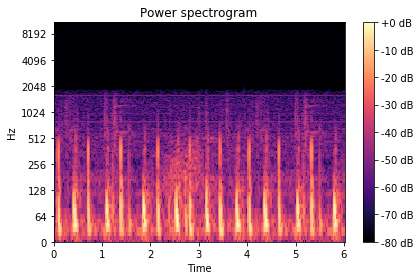

In [0]:
D = np.abs(librosa.stft(signal))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

### Filter Banks
The ability of human hearing to tell apart two frequencies is non-linear. It's easier to distinguish lower frequencies than it is to distinguish higher frequencies. The Mel-Scale models this phenomenon.
The Filter Banks used here are group of triangular filters used on the generated STFT. Thus the frequecies are grouped into different bins. The spacing between the filters vary according to the Mel-Scale. 
This can be represented as:
  ![alt text](https://haythamfayek.com/assets/posts/post1/mel_filters.jpg)
Image source: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

At lower frequency ranges the filters are closer and capture more details than the ones at the higher frequency ranges.

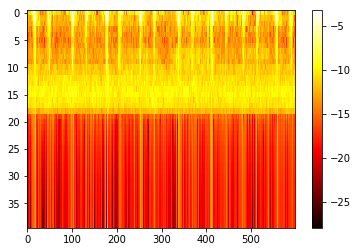

In [0]:
bank = logfbank(audio, sampling_rate, nfilt=40, nfft=int(0.025 * 22050)).T
plt.imshow(bank, cmap = 'hot', interpolation = 'nearest', aspect = 'auto')
plt.colorbar()

plt.show()

## Creating Filter Banks from audio data

In [0]:
#list to store data
X= []
Y = []

for row in tqdm(df.iterrows()):
  bank = logfbank(row[1]['audio'], 22050, nfilt=26, nfft=int(0.025 * 22050))
  X.append(bank)
  Y.append(row[1]['label'])

X = np.array(X)
Y = np.array(Y)

585it [00:21, 26.07it/s]


Following line of code handles class imbalance

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Splitting data into Train and Test sets

In [0]:
le = LabelEncoder()
Y_one_hot = to_categorical(le.fit_transform(Y))

x_train, x_test, y_train, y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state = 42) #42

print("Training Data Shape: " + str((x_train.shape, y_train.shape)))
print("Testing Data Shape: " + str((x_test.shape, y_test.shape)))

Training Data Shape: ((468, 598, 26), (468, 5))
Testing Data Shape: ((117, 598, 26), (117, 5))


## Finally, the model to classify the data!
Audio data is inherently sequential in nature. An architecture with **LSTM**s thus performs well given the ability of LSTMs to capture patterns that occur over long periods of time.

In [0]:
model = Sequential()

model.add(LSTM(32, return_sequences = True, input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences = True))
model.add(Dropout(0.25))

model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.08), bias_regularizer = l2(0.08)))
model.add(Dropout(0.4))

model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.08), bias_regularizer = l2(0.08)))
model.add(Dropout(0.4))

model.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.1), bias_regularizer = l2(0.1)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation = 'softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 598, 32)           7552      
_________________________________________________________________
dropout_19 (Dropout)         (None, 598, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 598, 32)           8320      
_________________________________________________________________
dropout_20 (Dropout)         (None, 598, 32)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 598, 64)           2112      
_________________________________________________________________
dropout_21 (Dropout)         (None, 598, 64)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 598, 64)          

In [0]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#mcp_save = ModelCheckpoint('/Weights/final_weights.{epoch:02d}-{val_acc:.2f}.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

num_epochs = 500
num_batch_size = 128

start = datetime.now()
history = model.fit(
            x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
            validation_data=(x_test, y_test), verbose=1, shuffle = True, 
            class_weight=class_weights#, callbacks = [mcp_save]
         )

duration = datetime.now() - start
print("Training completed in time: ", duration)

score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("training accuracy: %.4f%%" % accuracy)

Train on 468 samples, validate on 117 samples
Epoch 1/500
468/468 [==============================] - 11s 23ms/step - loss: 18.3553 - acc: 0.4060 - val_loss: 18.2208 - val_acc: 0.5641
Epoch 2/500
468/468 [==============================] - 8s 17ms/step - loss: 18.1540 - acc: 0.5684 - val_loss: 18.0944 - val_acc: 0.5641
Epoch 3/500
468/468 [==============================] - 8s 17ms/step - loss: 18.0230 - acc: 0.5021 - val_loss: 17.9834 - val_acc: 0.5641
Epoch 4/500
468/468 [==============================] - 8s 17ms/step - loss: 17.8427 - acc: 0.5534 - val_loss: 17.8456 - val_acc: 0.5641
Epoch 5/500
468/468 [==============================] - 8s 17ms/step - loss: 17.7216 - acc: 0.5577 - val_loss: 17.7302 - val_acc: 0.5641
Epoch 6/500
468/468 [==============================] - 8s 17ms/step - loss: 17.6325 - acc: 0.5406 - val_loss: 17.6194 - val_acc: 0.5641
Epoch 7/500
468/468 [==============================] - 8s 17ms/step - loss: 17.5677 - acc: 0.5128 - val_loss: 17.5172 - val_acc: 0.5641
E

## Plotting Learning History

<Figure size 1584x720 with 0 Axes>

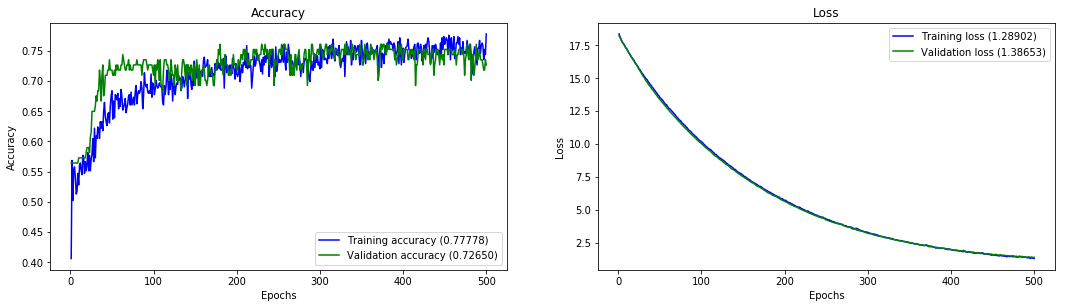

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    plt.figure(221, figsize=(18,10))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    
plot_history(history)

## Classification Results

Loading a better converged model with the same architecture trained on the same train-test distribution for longer. 

In [0]:
model = load_model('final_weights.870-0.78.hdf5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 598, 32)           7552      
_________________________________________________________________
dropout_7 (Dropout)          (None, 598, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 598, 32)           8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 598, 32)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 598, 64)           2112      
_________________________________________________________________
dropout_9 (Dropout)          (None, 598, 64)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 598, 64)          

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy: %2.2f' %(scores[1]*100))

117/117 [==============================] - 5s 40ms/step
Test loss: 0.7648176652753454
Test accuracy: 77.78


### Plotting the Confusion Matrix

In [0]:
predictions = model.predict(x_test, verbose=1)
y_true, y_pred = [],[]
classes = le.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

117/117 [==============================] - 4s 35ms/step


In [0]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.06 0.94]
 [0.   0.04 0.   0.77 0.19]
 [0.02 0.05 0.   0.   0.94]]


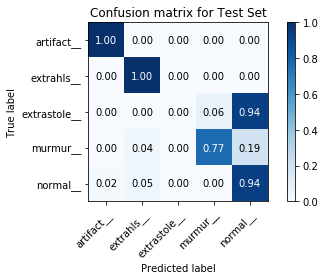

In [0]:
np.set_printoptions(precision=2)

# Ploting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, le, normalize=True,
                      title='Confusion matrix for Test Set')
plt.show()

### Future Work

The model performs well for all classes except extra-systole. On evaluating the audio closely, it is clear that extra-systoles occurs atleast once within the first 6 seconds, i.e. the length of input, of every audio file. Besides, majority of the files for extra-systole are close to 6 seconds. Thus, data augmentation could help with the situation.<br><br>
Augmentation approaches using Gaussian Mixture Models and Generative Adversarial Networks discussed in [Hatamian, F.N., Ravikumar, N., Vesal, S., Kemeth, F.P., Struck, M., Maier, A.: The eﬀect of data augmentation on classiﬁcation of atrial ﬁbrillation in short single-lead ecg signals using deep neural networks. In: ICASSP 2020-2020 IEEE InternationalConference on Acoustics, Speech and Signal Processing (ICASSP). pp. 1264–1268.IEEE (2020)](https://www.researchgate.net/publication/341084826_The_Effect_of_Data_Augmentation_on_Classification_of_Atrial_Fibrillation_in_Short_Single-Lead_ECG_Signals_Using_Deep_Neural_Networks) might prove useful.
<br>
<br>

---

Thanks for reading!